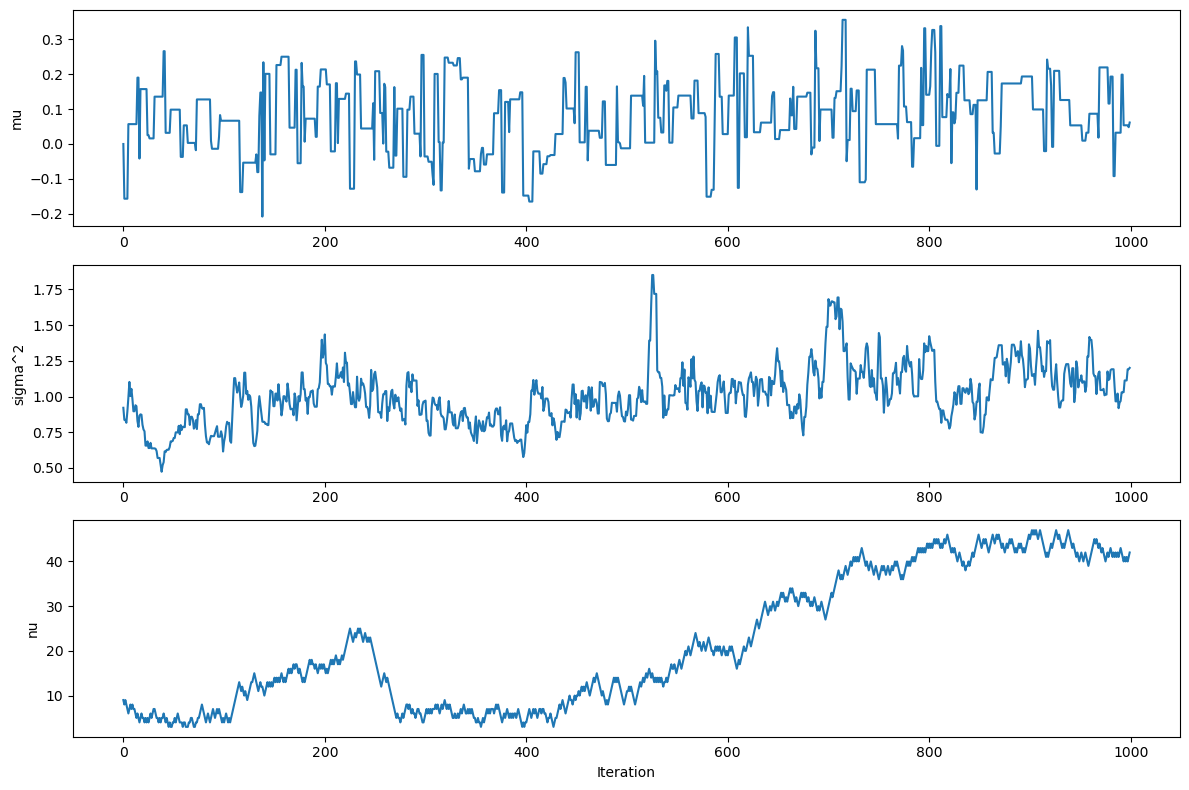

In [2]:
#Q1

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

# 设置随机种子以便复现结果
np.random.seed(1008111151)

# 生成模拟数据
def generate_data(n, true_mu, true_sigma2, true_nu):
    return true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

# 定义对数后验概率函数
def log_posterior(mu, sigma2, nu, x, mu0, tau0, sigma0):
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf

    log_likelihood = np.sum(
        gammaln((nu + 1) / 2) - gammaln(nu / 2) 
        - 0.5 * np.log(np.pi * nu * sigma2) 
        - ((nu + 1) / 2) * np.log(1 + ((x - mu)**2) / (nu * sigma2))
    )

    log_prior_mu = 0.5 * np.log(tau0 / (2 * np.pi)) - (tau0 / 2) * (mu - mu0)**2
    log_prior_sigma2 = 0.5 * np.log(2 / (np.pi * sigma0**2)) - (sigma2**2) / (2 * sigma0**2)
    log_prior_nu = -np.log(100)

    return log_likelihood + log_prior_mu + log_prior_sigma2 + log_prior_nu

def metropolis_step(current_value, proposal_value, log_post_current, log_post_proposal):
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        return proposal_value, log_post_proposal
    return current_value, log_post_current

def metropolis_within_gibbs(x, mu0, tau0, sigma0, iterations=1000):
    mu, sigma2, nu = 0.0, 1.0, 10
    log_post_current = log_posterior(mu, sigma2, nu, x, mu0, tau0, sigma0)

    mu_samples, sigma2_samples, nu_samples = np.zeros(iterations), np.zeros(iterations), np.zeros(iterations, dtype=int)

    mu_prop_sd, log_sigma2_prop_sd = 0.5, 0.1

    for t in range(iterations):
        mu_proposal = mu + np.random.normal(0, mu_prop_sd)
        log_post_proposal = log_posterior(mu_proposal, sigma2, nu, x, mu0, tau0, sigma0)
        mu, log_post_current = metropolis_step(mu, mu_proposal, log_post_current, log_post_proposal)
        mu_samples[t] = mu

        log_sigma2_current = np.log(sigma2)
        log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
        sigma2_proposal = np.exp(log_sigma2_proposal)
        log_post_proposal = log_posterior(mu, sigma2_proposal, nu, x, mu0, tau0, sigma0)
        sigma2, log_post_current = metropolis_step(sigma2, sigma2_proposal, log_post_current, log_post_proposal)
        sigma2_samples[t] = sigma2

        nu_proposal = nu + np.random.choice([-1, 1])
        nu_proposal = np.clip(nu_proposal, 1, 100)
        log_post_proposal = log_posterior(mu, sigma2, nu_proposal, x, mu0, tau0, sigma0)
        nu, log_post_current = metropolis_step(nu, nu_proposal, log_post_current, log_post_proposal)
        nu_samples[t] = nu

    return mu_samples, sigma2_samples, nu_samples

def plot_samples(mu_samples, sigma2_samples, nu_samples):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(mu_samples)
    plt.ylabel('mu')

    plt.subplot(3, 1, 2)
    plt.plot(sigma2_samples)
    plt.ylabel('sigma^2')

    plt.subplot(3, 1, 3)
    plt.plot(nu_samples)
    plt.ylabel('nu')
    plt.xlabel('Iteration')

    plt.tight_layout()
    plt.show()

def main():
    n = 100
    true_mu = 0.0
    true_sigma2 = 1.0
    true_nu = 5
    mu0, tau0, sigma0 = 0.0, 1.0, 1.0

    x = generate_data(n, true_mu, true_sigma2, true_nu)

    mu_samples, sigma2_samples, nu_samples = metropolis_within_gibbs(x, mu0, tau0, sigma0)

    plot_samples(mu_samples, sigma2_samples, nu_samples)

if __name__ == "__main__":
    main()

In [9]:
#Q2


import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import t

# 设置随机种子以确保结果可复现
np.random.seed(1008111151)

# 样本大小和模型的真实参数
sample_sizes = [50, 100, 500, 1000]
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

# 存储每个样本大小下的推断结果
results = {}

# 生成数据并执行PyMC3推断
def generate_data_and_run_inference(sample_size, true_mu, true_sigma, true_nu):
    # 生成 t 分布数据
    data = true_mu + true_sigma * t.rvs(df=true_nu, size=sample_size)
    
    # 定义PyMC3模型
    with pm.Model() as model:
        # 设置先验
        mu = pm.Normal("mu", mu=0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)

        # 观察数据，使用t分布
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)

        # 进行采样
        idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

    return idata

# 对每个样本大小执行推断并存储结果
for n in sample_sizes:
    results[n] = generate_data_and_run_inference(n, true_mu, true_sigma, true_nu)

# 输出每个样本大小下的自由度参数nu的后验摘要
for n in sample_sizes:
    print(f"Sample size: {n}")
    print(az.summary(results[n], var_names=["nu"]))
    print("=" * 50)  # 分隔线，便于查看结果


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  48.505  28.281     4.0     94.0      1.025    0.725     678.0     538.0   

    r_hat  
nu    1.0  
Sample size: 100
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  52.652  27.491     6.0     95.0      1.083    0.766     602.0     539.0   

    r_hat  
nu    1.0  
Sample size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.887  3.366     4.0     14.0      0.194    0.138     248.0     262.0   

    r_hat  
nu   1.01  
Sample size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  4.164  0.548     3.0      5.0      0.033    0.024     267.0     261.0   

    r_hat  
nu   1.01  


#Q3

We want slove that 

![](pdistribution.png)

The posterior predictive distribution is

![](h62.png)

Then we substitute the forms of the Normal distribution for yi and the Gamma distribution for $\tau_i$ into this integral:

![](h63.png)

After that, We can simplify the powers of $\tau_i$ specifically

![](h64.png)

Thus, the integrand become

![](h65.png)

Now, the expression resembles the Gamma distribution kernel

So we recognize that the integrand is the kernel of a Gamma distribution with the following parameter

Shape parameter
$$
a=\frac{\nu+1}{2}
$$
Rate parameter
$$
b=\frac{y_i^2+\nu}{2}
$$

Thus, the integral become

![](h66.png)

This integral is exactly the form of the Gamma distribution, and its result is

![](h67.png)

This result is the marginal distribution for yi. Next, we simplify the final expression. We observe the following

![](h68.png)                                          

The resulting distribution is a Student’s t-distribution, given by

![](h69.png)     

This is exactly the form of the Student’s t-distribution and finally, we have

![](h70.png)  


This derivation shows that by integrating out the uncertainty in the latent precision parameter, the resulting distribution for the observed data is a Student's t-distribution where integrating over latent parameters leads to a distribution with heavier tails, reflecting the increased uncertainty. 